# Introduction to PyTorch
This PyTorch summary is mainly based on https://pytorch.org/tutorials/beginner/basics/intro.html. 

## 1. Tensors
---

- very similar to arrays and matrices
- used to encode inputs and outputs of a model, as well as the model's parameters
- can run on GPUs
- optimized for automatic differentiation 

In [2]:
import torch 
import numpy as np 

#### Initializing a Tensor

In [2]:
# directly from data
data = [[1, 2], [3, 4]]
x_data = torch.tensor(data)

# from numpy array 
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

# random or constant value
shape = (2, 3)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

#### Attributes of a Tensor 
Tensor attributes describe their shape, datatype, and the device on which they are stored.

In [3]:
tensor = torch.rand(shape)
shape = tensor.shape # (3,4)
type = tensor.dtype # torch.float32
dev = tensor.device # type='cpu'

#### Moving Tensors to GPU 
By default tensors are created on CPU. You must explicitly move tensors to GPU (after checking for GPU availability). 

In [4]:
if torch.cuda.is_available(): 
    print("GPU resources are available")
    tensor = tensor.to("cuda")
print(tensor.device)

GPU resources are available
cuda:0


#### Operations on Tensors
Operations include arithmetic, linear algebra, matrix multiplication, and many more. Each operation can be run on GPU. Most of the operations are really similar to `numpy`. 

In [5]:
# Indexing & Slicing
tensor = torch.ones(4, 4)
first_row = tensor[0]
first_col = tensor[:, 0]
elem = tensor[0,0]

# Arithmetic Operations
y1 = tensor @ tensor.T # matrix multiplication
y2 = tensor * tensor   # element-wise product

## 2. Datasets & DataLoaders
---

- PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`
- allow to use pre-loaded datasets as well as your own data
- `Dataset` stores samples
- `DataLoder` wraps an iterable around the `Dataset` to easily access samples

#### Loading external Dataset
You can freely access pre-loaded datasets. For example, `FashionMNIST` is a dataset containing 60'000 training examples and 10'000 test examples. Each sample comprises a 28x28 grayscale image and an associated lablem from 10 classes. 


In [3]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data", # root is path where the train/test data is stored
    train=True, # specifies training or test dataset
    download=True, # downloads the data from Internet 
    transform=ToTensor() # specify the feature and label transformation
)

test_data = datasets.FashionMNIST(
    root="data", 
    train=False,
    download=True, 
    transform=ToTensor()
)

#### Iterating over Dataset & Visualization
You can index into the dataset using `training_data[index]`. 

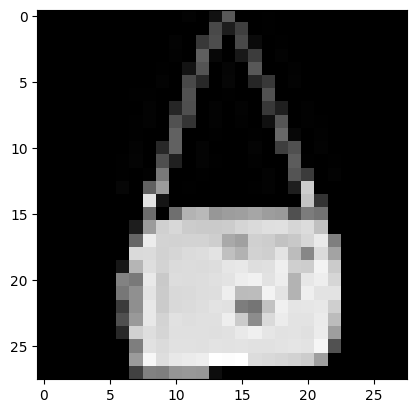

In [21]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Preparing your data for training with DataLoaders
While training, you typically pass samples in minibathces, and reshuffle the data in every epoch. 

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

#### Iterate through DataLoader
After having loaded the dataset into `DataLoader`, we can iterate through the dataset. Each iteration returns a batch of `train_features` and `train_labels` containing 64 features and labels. 

In [38]:
train_features, train_labels = next(iter(train_dataloader))
print(train_features.size())
print(train_labels.size())

img = train_features[0].squeeze()
label = train_labels[0]

torch.Size([64, 1, 28, 28])
torch.Size([64])


## 3. Neural Networks
---

`torch.nn` provides all the building blocks required to build your neural network. <br> Really useful resource: 
- https://pytorch.org/docs/stable/nn.html
- tuning hyperparameters: https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html


In [5]:
import os 
from torch import nn 
from torchvision import datasets, transforms

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


Define your own neural network by subclassing `nn.Module`, and initialize the layers in `__init__`. You must implement the operations on input data in the `forward` method. 

In [7]:
# NeuralNetworks class inherits from nn.Module 
class NeuralNetwork(nn.Module): 
    # constructor 
    # self refers to the instance of the class that is being created 
    # alsows object to access its attributes & methods 
    def __init__(self):
        # call constructor of nn.Module class 
        super().__init__() 
        # this layer flattens the input 
        # multi-dimensional input is transformed into 1D vector 
        self.flatten = nn.Flatten() 
        # define intermediate layers and activation functions
        self.linear_relu_stack = nn.Sequential( 
            nn.Linear(28 * 28, 512), # input layer: 784 to 512 units
            nn.ReLU(),               # ReLu activation
            nn.Linear(512, 512),     # hidden layer: 512 to 512 units
            nn.ReLU(),               # ReLu activation
            nn.Linear(512, 10)       # output layer: 512 to 10 units (for classification)
        )
    # defines how input x flows through layers 
    # this function is called automatically, don't call it yourself! 
    def forward(self, x): 
        # input is always flattened before being passed to next layer 
        x = self.flatten(x)
        # flattened input is passed though sequential stack of linear and ReLU layers
        # output is tensor called logits
        logits = self.linear_relu_stack(x)
        # output is typically passed then to loss function or activation function
        return logits

Now, create an instance of `NeuralNetwork`, and move it to your GPU. 

In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [9]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
print("Class probabilities:", pred_probab)
y_pred = pred_probab.argmax(1)
print("Predicted class:", y_pred)

Class probabilities: tensor([[0.1101, 0.1107, 0.0985, 0.0929, 0.0946, 0.0971, 0.0998, 0.0999, 0.0987,
         0.0976]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Predicted class: tensor([1], device='cuda:0')


#### Going into Details

In [10]:
# input batch of 3 images of size 28x28
input_image = torch.rand(3, 28, 28) 
input_image.size()

torch.Size([3, 28, 28])

#### nn.Flatten
We convert our three 2-dimensional 28x28 images into three 1-dimensional 784 images.

In [11]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
flat_image.size()

torch.Size([3, 784])

#### nn.Linear
Apply linear transformation on the input using its stored weights and biases. 

In [12]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
hidden1.size()

torch.Size([3, 20])

#### nn.ReLU
Introduce nonlinearity, helping neural networks to learn complex relations. You can observe that negative values are 

In [13]:
print("Before ReLU:", hidden1)
relu = nn.ReLU()
hidden1 = relu(hidden1)
print("After ReLU:", hidden1)

Before ReLU: tensor([[ 0.3229,  0.1037, -0.2146, -0.1409,  0.2887, -0.2952, -0.0498, -0.7032,
          0.1779, -0.1321,  0.0843,  0.0864, -0.3566,  0.4613,  0.3330, -0.4496,
          0.5064, -0.3268, -0.2587, -0.3868],
        [ 0.4221,  0.3423, -0.1939, -0.0010,  0.2715, -0.0034, -0.3342, -0.6018,
          0.2680, -0.0037,  0.0637,  0.0131,  0.1864,  0.1821,  0.4224, -0.6231,
          0.1404, -0.3224, -0.6558, -0.4040],
        [ 0.1256,  0.1455, -0.0943, -0.3716,  0.1173, -0.1546, -0.2580, -0.1659,
          0.3310, -0.0741, -0.2854,  0.0939,  0.2930,  0.1903,  0.3121, -0.2703,
          0.2233, -0.4708, -0.7156, -0.2854]], grad_fn=<AddmmBackward0>)
After ReLU: tensor([[0.3229, 0.1037, 0.0000, 0.0000, 0.2887, 0.0000, 0.0000, 0.0000, 0.1779,
         0.0000, 0.0843, 0.0864, 0.0000, 0.4613, 0.3330, 0.0000, 0.5064, 0.0000,
         0.0000, 0.0000],
        [0.4221, 0.3423, 0.0000, 0.0000, 0.2715, 0.0000, 0.0000, 0.0000, 0.2680,
         0.0000, 0.0637, 0.0131, 0.1864, 0.1821, 0.4224

#### Model Parameters 
Recall that all the layers within your neural network are parameterized, i.e. have weights that are optimized during training. You can access the parameters using `parameters()` or `named_parameters()`. 

In [16]:
print("Model Structure:", model)

for name, parameter in model.named_parameters(): 
    print(f"Layer: {name} | Size: {parameter.size()} | Values : {parameter[:2]} \n")

Model Structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0243,  0.0167, -0.0194,  ...,  0.0296, -0.0082,  0.0232],
        [-0.0179,  0.0143, -0.0002,  ...,  0.0284, -0.0255,  0.0004]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0239, -0.0044], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0146,  0.0002, -0.0413,  ..., -0.0398, -0.0345, -0.0075],
        [ 0.0190, -0.0132, -0.0306,  ..., -0.0389, -0.0376, -0.0229]],
       device='cuda:0', grad_fn=<Slic

## Training Neural Networks using Automatic Differentiation
---
In back propagation, the parameters are adjusted according to the gradient of the loss function wrt. to the given parameter. To compute those gradients, PyTorch provides a built-in differentiation enginve called `torch.autograd`. 

Consider the simplest neural network with one-layer. We must compute the gradient with wrt. $w$ and $b$. We do so by setting `requires_grad=True` to indicate that we must differentiate the loss function wrt. to those parameters. 

In [26]:
x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True) # important
b = torch.randn(3, requires_grad=True)    # important
z = torch.matmul(x, w) + b 
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

To compute those derivates under some fixed $x$ and $y$, call the function `loss.backward()`, and then retrieve the values from `w.grad` and `b.grad`. 

In [27]:
loss.backward()
w_grad = w.grad
b_grad = b.grad

## Optimizing Neural Network Parameters
---

Until now we have learned, how to build a neural network and how to compute the gradient in a single point. However, training a neural network is an iterative process, where in each iteration, the neural network makes a guess about the output, computes the error in its guess, collects the derivatives of the error wrt. to its parameters, and optimizes these parameters using gradient descent.  

In the following, we build a neural network for multi-classification based on the `FashionMNIST` dataset. 

In [22]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data", 
    train=True, 
    download=True, 
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), 
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(), 
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork()
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = NeuralNetwork().to(device)

#### Hyperparameters
The following hyperparameters are important for training: 
- **Number of Epochs:** number of times to iterate over the dataset
- **Batch Size:** number of data samples propagated through the network before the parameters are updated
- **Learning Rate**: how much to update models parameters at each batch/epoch

In [23]:
learning_rate = 1E-3
batch_size = 64
epochs = 5

#### Optimization Loop
Train and optimize the neural network with an optimization loop. Each iteration of the optimization loop is called an **epoch**. Each epoch consists of two parts: 
- **Training Loop:** iterate over the training data and try to converge to optimal parameters
- **Validation:** iterate over test data to check if model performance is improving

Optimization inside the loop happens in three steps: 
- Call `optimizer.zero_grad()` to reset the gradients of model parameters at each iteration. This is done since gradients are added up by default.
- Backpropagate the prediction loss with a call to `loss.backward()`
- Once the gradient is computed, call `optimizer.step()` to update the parameters

#### Loss Function
Commonly used loss functions include `nn.MSELoss` (mean squared error) for regression, and `nn.NLLoss` (negative log likelihood) for classification. `nn.CrossEntropyLoss` combines `nn.LogSoftmax` and `nn.NLLLoss`. 
```python
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
```

#### Optimizer
A commonly used optimization algorithm is Stochastic Gradient Descent. You can find more optimizers here: https://pytorch.org/docs/stable/optim.html <br>
Initialize the optimizer by registering the model's parameters that need to be trained (weights and bias), and passing in the learning rate. 
```python
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
```

#### Full Implementation of Optimization Loop

In [24]:
def train_loop(dataloader, model, loss_fn, optimizer): 
    
    # total number of samples in dataset
    size = len(dataloader.dataset)
    
    # puts model into training mode 
    model.train()
    
    # iterate over each batch of data 
    # batch = index of current batch
    # (X, y) = input features and corresponding features 
    for batch, (X, y) in enumerate(dataloader): 
        # moving to GPU
        X, y = X.to(device), y.to(device)
        
        # model generates predictions based on input batch X 
        pred = model(X)  
        # prediction error 
        loss = loss_fn(pred, y)

        # performs backpropagation, calculating gradient of loss wrt parameters 
        loss.backward()
        # updates model parameters using computed gradient 
        optimizer.step()
        # reset gradient for next iteration since they accumulate 
        optimizer.zero_grad()

        # every 100 batches, print current loss
        if batch % 100 == 0: 
            # converts loss tensor into float 
            loss = loss.item() 
            # how many samples have been processed so far
            current = batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [25]:
def test_loop(dataloader, model, loss_fn):

    # puts model in evaluation mode 
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0 

    # disables gradient calculation to ensure that no parameters are updated 
    with torch.no_grad():

        # loop through batches 
        for X, y in dataloader:
            # moving to GPU
            X, y = X.to(device), y.to(device)
            # model generates predictions based on input batch X 
            pred = model(X)
            # update loss 
            test_loss += loss_fn(pred, y).item()
            # count correct predictions (classification)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305279  [   64/60000]
loss: 2.300761  [ 6464/60000]
loss: 2.279824  [12864/60000]
loss: 2.275269  [19264/60000]
loss: 2.262370  [25664/60000]
loss: 2.231902  [32064/60000]
loss: 2.242961  [38464/60000]
loss: 2.210954  [44864/60000]
loss: 2.206213  [51264/60000]
loss: 2.182332  [57664/60000]
Test Error: 
 Accuracy: 45.9%, Avg loss: 2.173689 

Epoch 2
-------------------------------
loss: 2.176937  [   64/60000]
loss: 2.180639  [ 6464/60000]
loss: 2.121284  [12864/60000]
loss: 2.142006  [19264/60000]
loss: 2.104252  [25664/60000]
loss: 2.037495  [32064/60000]
loss: 2.072766  [38464/60000]
loss: 1.999086  [44864/60000]
loss: 1.994117  [51264/60000]
loss: 1.939277  [57664/60000]
Test Error: 
 Accuracy: 61.2%, Avg loss: 1.929430 

Epoch 3
-------------------------------
loss: 1.946602  [   64/60000]
loss: 1.937617  [ 6464/60000]
loss: 1.817015  [12864/60000]
loss: 1.862474  [19264/60000]
loss: 1.768032  [25664/60000]
loss: 1.696554  [32064/600